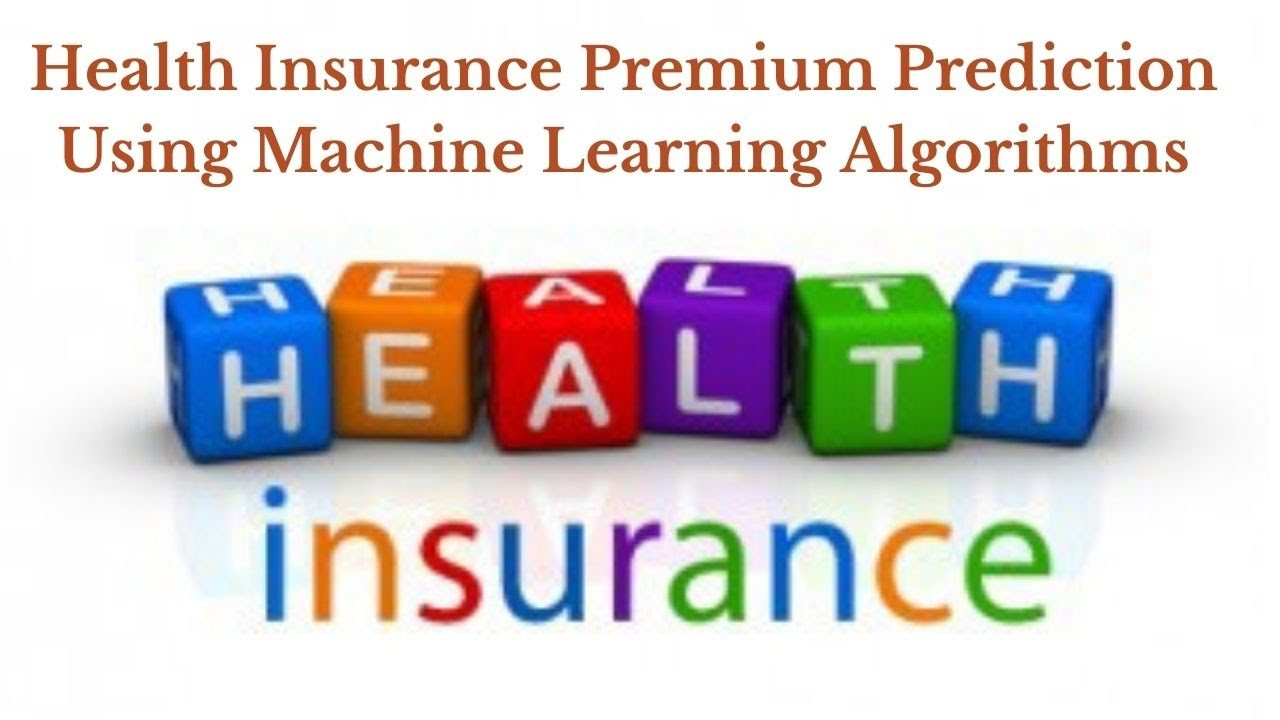

#Insurance prediction premium


In [ ]:
import pandas as pd
import numpy as np
import statsmodels
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import files
uploaded =files.upload()

In [ ]:
# Let us load the dataset
df = pd.read_csv("insurance.csv")

In [ ]:
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer.

Our objective is to find a way to estimate the value in the "expenses" column using the values in the other columns. We can do it for the historical data, then we will estimate expenses for new customers, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" ([body mass index](https://en.wikipedia.org/wiki/Body_mass_index)) and "expenses" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical columns:

In [ ]:
# Let us see statistical information about the Numerical features
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "expenses" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.


> 1. The range of expenses in the numerical column seems to have lot of difference in 75 percentile and the maximun expenses it looks like outliers. So we will handle that outlierr.
> 2. The range of the bmi in the numerical columns seems to have little difference in 75  percentile and the maximum bmi value.
> 3. Almost 50 percent of the customers have one child.

In [ ]:
# Let us see more statiscal information of the categorical features
df.describe(include="O")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


## Exploratory Analysis and Visualization

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "expenses" and other columns.

We'll use libraries Matplotlib, Seaborn and Plotly for visualization.


The following settings will improve the default style and font sizes for our charts.

In [ ]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [ ]:



fig = px.histogram(df,
                   x='age',
                   marginal='box',
                   nbins=47,
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages.


### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [ ]:
fig = px.histogram(df,
                    x='bmi',
                    marginal='box',
                    title='Distribustion of BMI (Body Mass Index)')

fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) centered around the value 30, with a few outliers towards the right. Here's how BMI values can be interpreted ([source](https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html)):

![](https://i.imgur.com/lh23OiY.jpg)


### Expenses

Let's visualize the distribution of "expenses" i.e. the annual medical expenses for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the expenses for smokers and non-smokers.

In [ ]:
fig = px.histogram(df,
                    x='expenses',
                    marginal='box',
                    color='smoker',
                    color_discrete_sequence=['green', 'orange'],
                    title="Annual Medical Expenses")

fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

* For most customers, the annual medical expenses are under 10k. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is 7.3k, the median for smokers is close to 35k.


### Charges and Gender

Let us visualize the distribution of "expenses" with the categorical column "sex" to distinguish the expenses for "male" and "female"

In [ ]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="sex",
                    color_discrete_sequence=["blue", "purple"],
                    title="Annual Medical Expenses by Sex")

fig.update_layout(bargap=0.1)
fig.show()

We can make following observation from the graph

* There is a significant difference in expenses between male and female. While the median for male and female is almost same but upper fence for male is 42k, the upper fence for female is close to 28k.

### DIstribution of expenses with Region

Let's visualize the distribution of "expenses" with categorical column "region" to distinguish expenses for southwest, southeast, northwest and northeast.

In [ ]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="region",
                    color_discrete_sequence=["grey", "orange", "green","violet"],
                    title="Annual Medical Expenses by Region")

fig.update_layout(bargap=0.1)
fig.show()

We make some obervation from the above graph

* There is significant difference in expenses for southeast, southwest, northeast and northwest. While the median for southwest is 8798 , the median for southeast is close to 9294, the median for northwest is 8965 and median for northeast is 10.05k.
*  And the upper fence for southwest is close to  26k, upper fence for southeast is close to 42k, upper fence for northwest is close to 4230kk and the upper fence for northeast is close to 34k.

### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [ ]:
px.histogram(df, x="smoker", color="sex", title="Smoker")

From the above graph we make some observations.

* It appears that 20% of the customers have reported they smoking.
* We can also see that smoking appears a more common habit among males.

In [ ]:
px.histogram(df, x="region", color="smoker", title="Region")

### Age and Charges

Let's visualize the relationship between "age" and "expenses" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

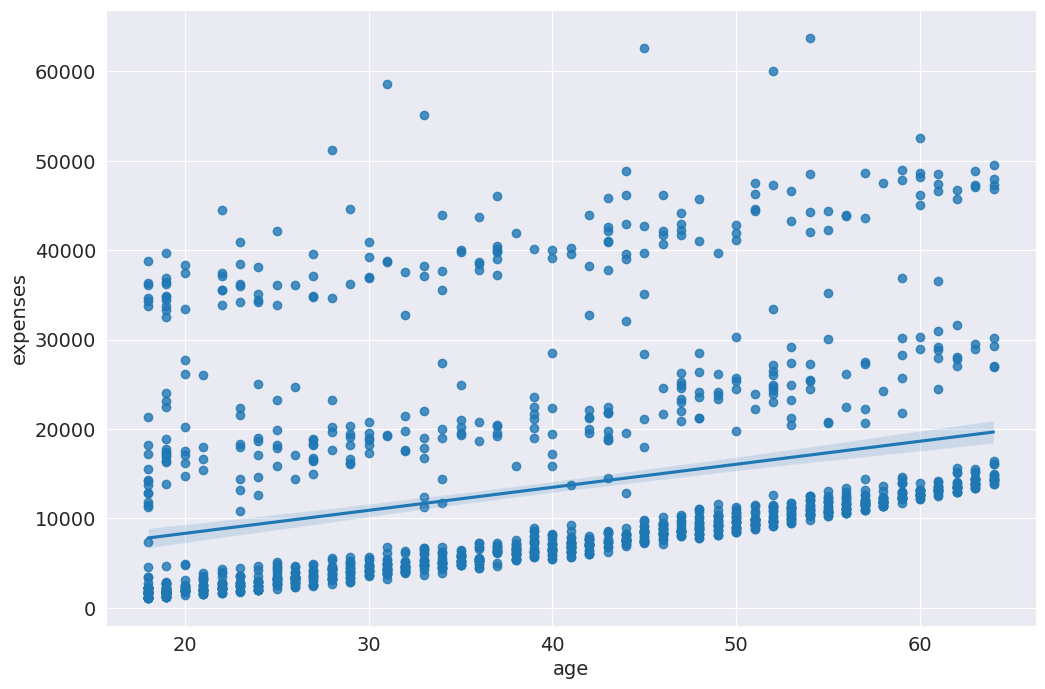

In [ ]:

# Relationship between features and expenses
plt.figure(figsize=(12, 8))
sns.regplot(x="age", y="expenses", data=df)
plt.show()

We can make the following observations from the above chart:

* The general trend seems to be that medical expenses increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical expenses.


* We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

     1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical expenses compared to others
     
     2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.
     


### BMI and Expenses

Let's visualize the relationship between BMI (body mass index) and expenses using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

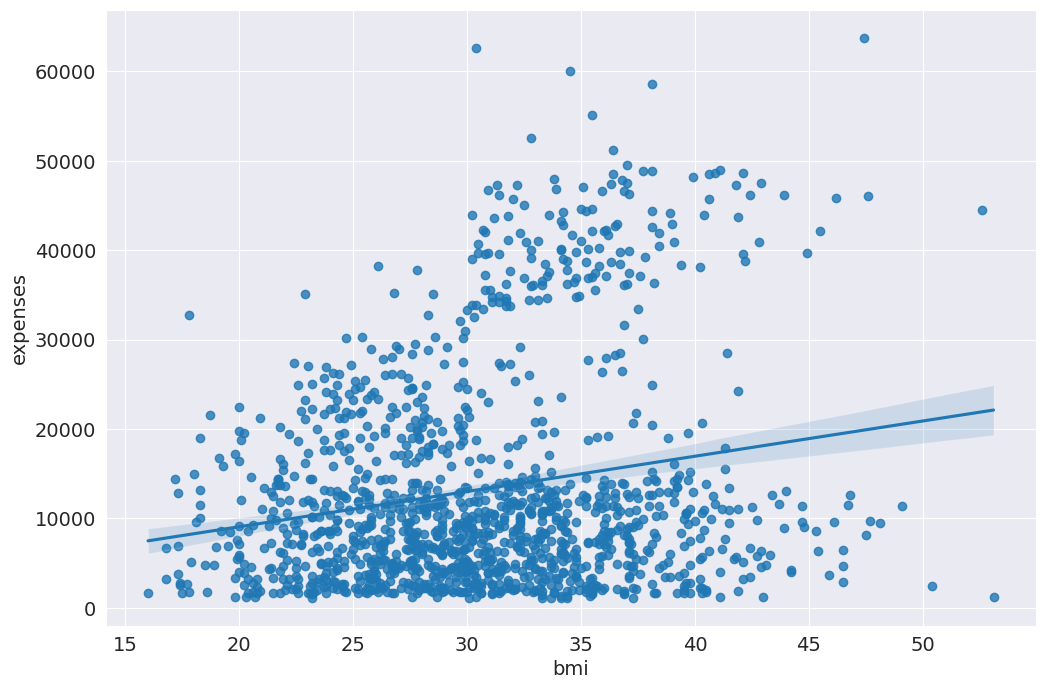

In [ ]:
plt.figure(figsize=(12, 8))
sns.regplot(x="bmi", y="expenses", data=df)
plt.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical expenses. However, medical expenses seem to be significantly higher for smokers with a BMI greater than 30.


###Children and Expenses

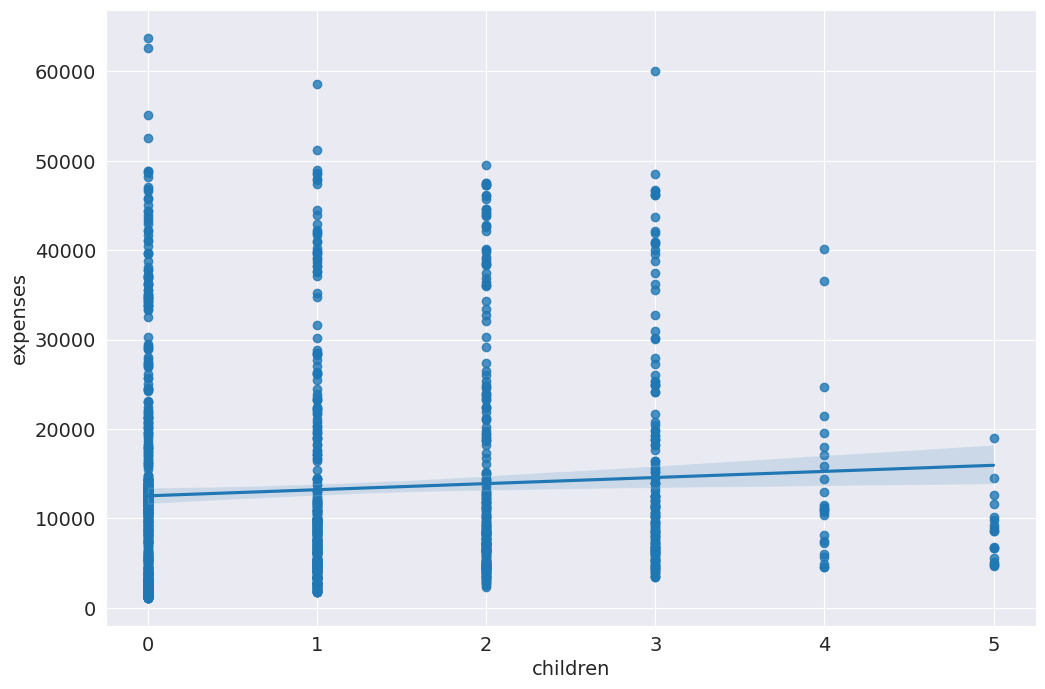

In [ ]:
plt.figure(figsize=(12, 8))
sns.regplot(x="children", y="expenses", data=df)
plt.show()

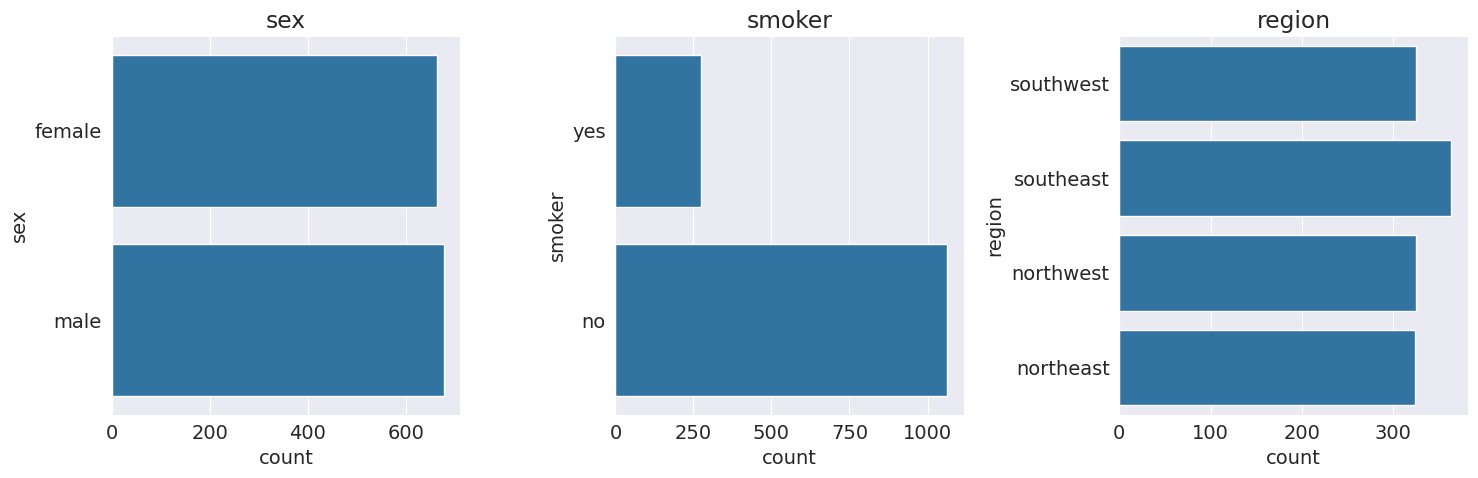

In [ ]:
# Distribution of categorical features
categorical_features = ["sex", "smoker", "region"]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(categorical_features):
    sns.countplot(df[feature], ax=axs[i])
    axs[i].set_title(feature)
plt.tight_layout()
plt.show()


### Correlation

In [ ]:
df.corr(numeric_only=True)

,age,bmi,children,expenses
age,1.000000,0.109341,0.042469,0.299008
bmi,0.109341,1.000000,0.012645,0.198576
children,0.042469,0.012645,1.000000,0.067998
expenses,0.299008,0.198576,0.067998,1.000000


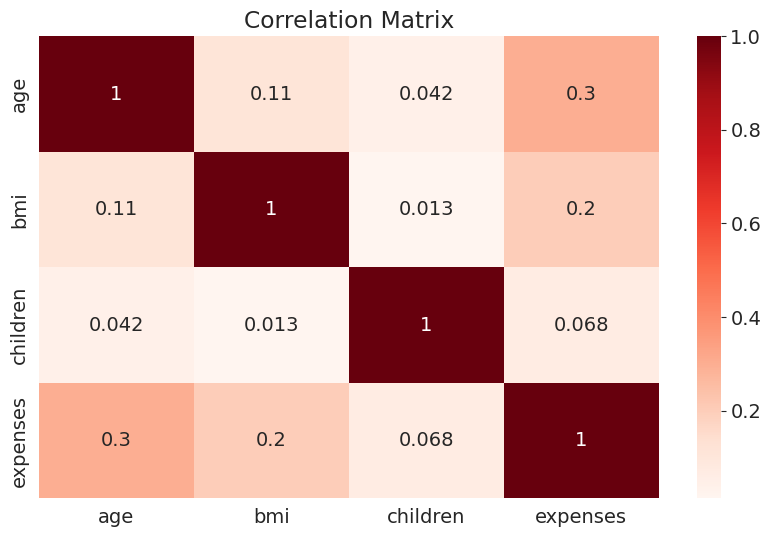

In [ ]:
sns.heatmap(df.corr(numeric_only=True), cmap='Reds', annot=True) #calculate correlation only on numerical columns
plt.title('Correlation Matrix')
plt.show()
#sns.heatmap(df.corr(), cmap='Reds', annot=True)
#plt.title('Correlation Matrix')

**Correlation vs causation fallacy:** Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features $X$ and $Y$ can be correlated if $X$ causes $Y$ or if $Y$ causes $X$, or if both are caused independently by some other factor $Z$, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that $X$ are $Y$ simply appear to be correlated because the sample is too small.


As you can tell from the analysis, the values in some columns are more closely related to the values in "expenses" compared to other columns. E.g. "age" and "expenses" seem to grow together, whereas "bmi" and "expenses" don't.

This relationship is often expressed numerically using a measure called the _correlation coefficient_, which can be computed using the `.corr` method of a Pandas series.

In [ ]:
print(df.expenses.corr(df.age))
print(df.expenses.corr(df.bmi))

0.2990081922850828
0.19857625501893206


To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [ ]:
df.expenses.corr(df.smoker.map({'yes': 1, 'no': 0}))

0.7872514298985541

Pandas dataframes also provide a `.corr` method to compute the correlation coefficients between all pairs of numeric columns.

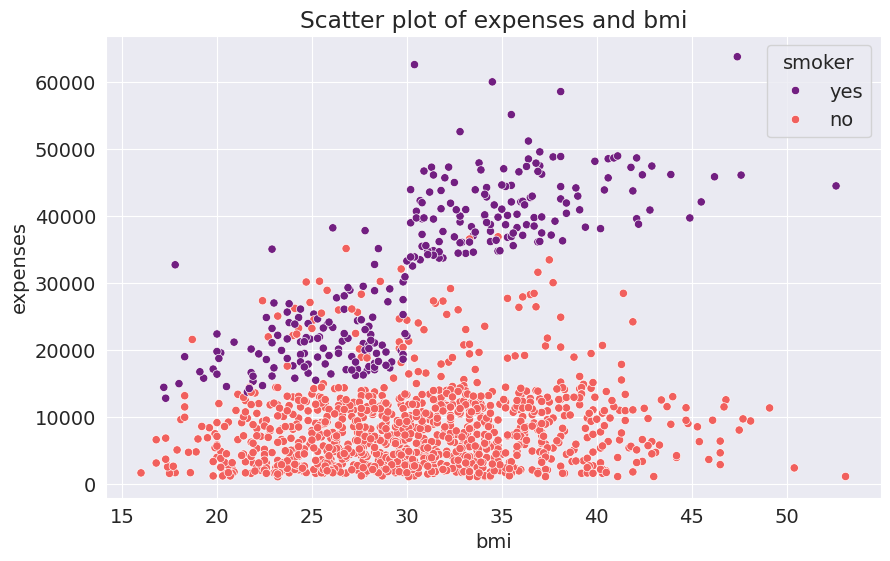

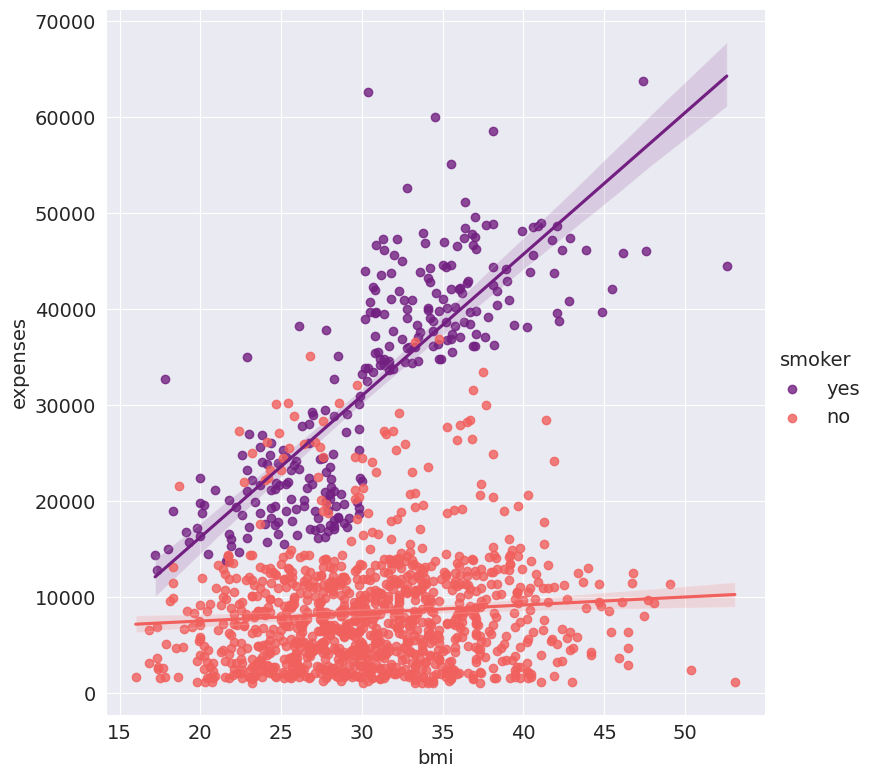

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='expenses',data=df,palette='magma',hue='smoker')
ax.set_title('Scatter plot of expenses and bmi')

sns.lmplot(x="bmi", y="expenses", hue="smoker", data=df, palette = 'magma', height = 8)


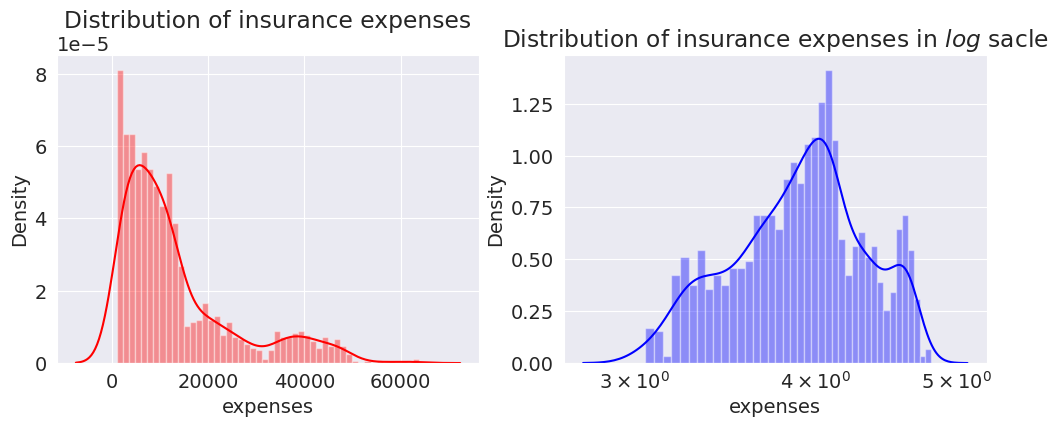

In [ ]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.distplot(df['expenses'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of insurance expenses')

ax=f.add_subplot(122)
sns.distplot(np.log10(df['expenses']),bins=40,color='b',ax=ax)
ax.set_title('Distribution of insurance expenses in $log$ sacle')
ax.set_xscale('log');


If we look at the left plot the expenses varies from 1120 to 63500, the plot is right skewed. In right plot we will apply natural log, then plot approximately tends to normal. for further analysis we will apply log on target variable charges.

###  **Data** **Preprocessing**

Feature Selection: We begin by selecting the relevant features (age, bmi, children, sex, smoker, region) from the dataset to predict the target variable, which is expenses (annual medical expenses).

Handling Categorical Variables: Since sex, smoker, and region are categorical features, we use one-hot encoding to convert these categorical variables into numerical values. One-hot encoding creates binary columns for each level of a categorical feature.

Standardization: We standardize the numerical features (age, bmi, children) using StandardScaler. This step scales the data to have a mean of 0 and a standard deviation of 1, ensuring that each feature contributes equally to the model, especially for models like Support Vector Regression (SVR) that are sensitive to feature scaling.

In [ ]:
# Import necessary libraries for model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import pandas as pd

In [ ]:
# Feature columns
X = df[['age', 'bmi', 'children', 'sex', 'smoker', 'region']]  # Features
y = df['expenses'] # Target

In [ ]:
# Convert categorical variables to numeric
X = pd.get_dummies(X, drop_first=True)  # One-hot encode categorical columns

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###**Model** **Building**

####1. Multiple Linear Regression

Multiple Linear Regression (LR): Linear regression is a statistical method that models the relationship between the dependent variable (expenses) and one or more independent variables (age, bmi, children, etc.). We use the LinearRegression() model from sklearn to fit the training data.

In [ ]:
# Multiple Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)

#### 2. Random Forest Regressor

Random Forest Regressor (RF): Random Forest is an ensemble method that builds multiple decision trees and aggregates their predictions to improve accuracy and reduce overfitting. We use RandomForestRegressor() from sklearn to fit the model.

In [ ]:
# Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

#### 3. Gradient Boosting Regressor

Gradient Boosting Regressor (GB): Gradient Boosting is another ensemble method where models are built sequentially, and each model corrects the errors of the previous one. It is known for performing well in regression tasks. We use GradientBoostingRegressor() from sklearn.

In [ ]:
# Gradient Boosting Regressor
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)

#### 4. Support Vector Regressor(SVR)

Support Vector Regression (SVR): SVR is a regression version of Support Vector Machines. It tries to fit the data within a predefined margin of tolerance. SVR is particularly useful when there is a non-linear relationship between features and the target variable.

In [ ]:
# Support Vector Regression
model_svr = SVR()
model_svr.fit(X_train_scaled, y_train)
y_pred_svr = model_svr.predict(X_test_scaled)

#### 5. XGBoost Regressor

XGBoost Regressor (XGB): XGBoost is an optimized gradient boosting algorithm designed for speed and performance. It is widely used in machine learning competitions for its accuracy and efficiency. We use XGBRegressor() from the xgboost library.

In [ ]:
# XGBoost Regressor
model_xgb = xgb.XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

Training and Prediction:

For each model, we first train the model on the training data using the fit() method. Then, we use the trained model to make predictions on the test data using the predict() method.

### **Model** **Evaluation**



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

In [ ]:
# Evaluation function
def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    cv = np.mean(np.abs((y_test - y_pred)/ y_test)) * 100

    print(f"Evaluation for {model_name}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared: {r2}")
    print(f"Cross Validation:{cv}")
    print("-" * 40)

    # Return the calculated metrics
    return mae, mse, rmse, r2,cv

# Assuming y_test, y_pred_lr, y_pred_rf, etc. are defined somewhere in your code
# Evaluate all models and store the metrics
mae_lr, mse_lr, rmse_lr, r2_lr, cv_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")
mae_rf, mse_rf, rmse_rf, r2_rf, cv_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")
mae_gb, mse_gb, rmse_gb, r2_gb, cv_gb = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
mae_svr, mse_svr, rmse_svr, r2_svr, cv_svr = evaluate_model(y_test, y_pred_svr, "Support Vector Regression")
mae_xgb, mse_xgb, rmse_xgb, r2_xgb, cv_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")


models = [('Linear Regression', mae_lr, mse_lr, rmse_lr, r2_lr, cv_lr),
          ('Random Forest', mae_rf, mse_rf, rmse_rf, r2_rf, cv_rf),
          ('Gradient Boosting', mae_gb, mse_gb, rmse_gb, r2_gb, cv_gb),
          ('Support Vector Regression', mae_svr, mse_svr, rmse_svr, r2_svr, cv_svr),
          ('XGBoost', mae_xgb, mse_xgb, rmse_xgb, r2_xgb, cv_xgb)
         ]

Evaluation for Linear Regression:
Mean Absolute Error (MAE): 4181.561524000794
Mean Squared Error (MSE): 33600065.35507784
Root Mean Squared Error (RMSE): 5796.556335884077
R-squared: 0.7835726930039905
Cross Validation:46.89798689833871
----------------------------------------
Evaluation for Random Forest:
Mean Absolute Error (MAE): 2545.6428549093816
Mean Squared Error (MSE): 20883861.261204492
Root Mean Squared Error (RMSE): 4569.886351016236
R-squared: 0.8654812779476422
Cross Validation:32.204374554362936
----------------------------------------
Evaluation for Gradient Boosting:
Mean Absolute Error (MAE): 2467.076502636923
Mean Squared Error (MSE): 18700721.18496627
Root Mean Squared Error (RMSE): 4324.433047807108
R-squared: 0.8795434865327185
Cross Validation:29.705668968305236
----------------------------------------
Evaluation for Support Vector Regression:
Mean Absolute Error (MAE): 8612.410381673724
Mean Squared Error (MSE): 166128973.0356349
Root Mean Squared Error (RMSE): 

In [ ]:
# Create the DataFrame
predict = pd.DataFrame(data=models, columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2_Score','Cross Validation'])
predict

,Model,MAE,MSE,RMSE,R2_Score,Cross Validation
0,Linear Regression,4181.561524,3.360007e+07,5796.556336,0.783573,46.897987
1,Random Forest,2545.642855,2.088386e+07,4569.886351,0.865481,32.204375
2,Gradient Boosting,2467.076503,1.870072e+07,4324.433048,0.879543,29.705669
3,Support Vector Regression,8612.410382,1.661290e+08,12889.102879,-0.070083,113.128236
4,XGBoost,3148.127577,2.872111e+07,5359.207636,0.814999,43.194535


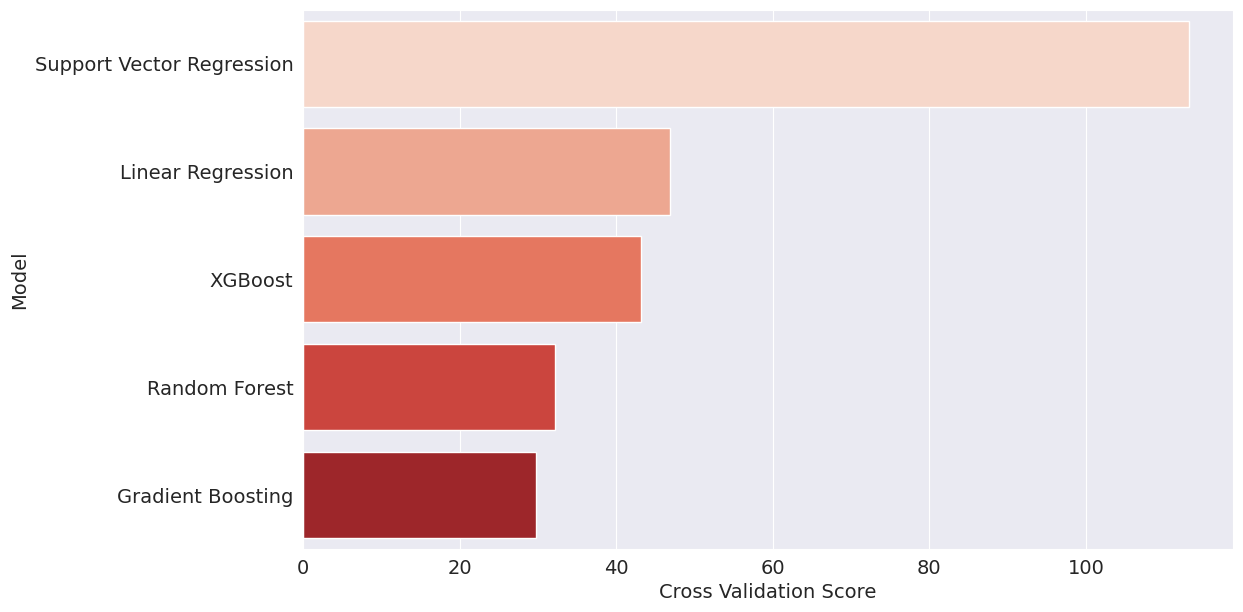

In [ ]:
plt.figure(figsize=(12,7))
predict.sort_values(by=['Cross Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross Validation', y='Model',data = predict, palette='Reds')
plt.xlabel('Cross Validation Score')
plt.ylabel('Model')
plt.show()